In [1]:
#%load_ext nb_black
import findspark
findspark.init() 
findspark.find()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("Classification with Spark").getOrCreate()

**Note**

spark.mllib library contains the legacy API built on top of RDDs and hence all functionalities of mllib work in RDD.

spark.ml library provides higher-level API built on top of DataFrames for constructing ML pipelines and it works on DataFrames.

## Data loading

In [75]:
#reading csv file
df = spark.read.csv("C:/Users/toami/OneDrive/Desktop/Data Science/SEM2/BIG DATA/SPARK/assignment/tabular-playground-series-mar-2021/train.csv", inferSchema=True, header=True)
df2=df.toPandas()
df2

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,N,F,A,E,BU,A,AS,K,...,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007,0
299996,499995,A,K,A,A,G,BI,A,K,AE,...,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939,0
299997,499996,A,G,M,A,H,BI,C,L,F,...,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144,1
299998,499997,B,H,A,D,B,BI,A,AA,AX,...,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822,0


## Data Cleaning

In [76]:
#dropping id column
df = df.drop("id")

In [77]:
#checking null and NaN values in train data
from pyspark.sql.functions import isnan, when, count, col
df3=df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
df3

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
#Removing duplicates and NAs from train data
#df=df.dropna()
df=df.dropDuplicates()

## Data Statistics

In [93]:
#number of rows and columns
print("DataFrame  have {0} rows and {1} columns" .format(df.count(), len(df.columns)))

DataFrame  have 300000 rows and 31 columns


In [78]:
#categorical and numerical columns
def get_dtype(df):
    cat=[]
    num=[]
    for x in df.dtypes:
        if x[1]=='string':
            cat.append(x[0])
        else:
            num.append(x[0])
    return (cat,num)
cat=get_dtype(df)[0]
num=get_dtype(df)[1]
print("Number of numericla features is ",len(num))
print("Number of categorical features is ",len(cat))

Number of numericla features is  12
Number of categorical features is  19


## summary statistics

In [6]:
#summary of numerical features
df.select(num).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
cont0,300000,0.5047487736598572,0.2067876274838243,-0.049561669672344405,1.0045591801131812
cont1,300000,0.49407325218061093,0.21303658009419457,0.08448021241887371,1.0099581520188259
cont2,300000,0.5166315346233755,0.21485103126763158,0.09449347051544164,1.0166000095661805
cont3,300000,0.47423477096676664,0.21663581794247805,-0.045315544085700266,0.9521869709580062
cont4,300000,0.5048478037630462,0.2274738365500208,0.16807077712366736,0.8585777089071495
cont5,300000,0.5022572768886236,0.24124318958524635,-0.03637924631902362,0.8530217010483966
cont6,300000,0.48822873988229226,0.211334505011812,0.00519916083437319,0.9665529928913124
cont7,300000,0.501738573431499,0.2034959382761562,0.09090146898913247,1.0358178214967186
cont8,300000,0.48807430240553795,0.17904837510647764,0.02413894871570244,1.0558848532285834


In [109]:
#summary of categorical features
d = []
df1=df[cat].toPandas()
for x in cat:
    d.append((x, df1[x].unique(), df1[x].nunique()))

df_cat=pd.DataFrame(d, columns=("Feature","Unique_Values","Count"))
df_cat

,Feature,Unique_Values,Count
0,cat0,"[A, B]",2
1,cat1,"[I, K, A, F, L, N, J, M, O, B, H, G, C, D, E]",15
2,cat2,"[A, G, C, O, D, F, Q, J, L, I, M, H, U, N, R, ...",19
3,cat3,"[B, A, C, D, G, N, H, F, E, K, I, J, L]",13
4,cat4,"[B, E, H, I, D, F, G, M, K, J, T, C, L, P, S, ...",20
5,cat5,"[BI, AB, BU, M, T, K, L, CG, BG, CI, N, G, X, ...",84
6,cat6,"[A, K, C, I, G, E, M, F, O, D, Q, S, B, Y, U, W]",16
7,cat7,"[S, W, E, Y, G, AV, AF, AK, AH, AN, J, H, U, A...",51
8,cat8,"[Q, AD, BM, Y, AG, AE, AX, H, BD, AO, X, L, M,...",61
9,cat9,"[A, F, L, C, E, I, J, N, V, R, D, X, B, Q, W, ...",19


### Finding Correlation
To check if numerical features are highly correlated. If features are correlated, they can be considered for dimension reduction.

Exception ignored in: <function JavaModelWrapper.__del__ at 0x000001B03F844948>
Traceback (most recent call last):
  File "C:\Program Files\Spark\spark-3.1.1-bin-hadoop2.7\python\pyspark\mllib\common.py", line 137, in __del__
    self._sc._gateway.detach(self._java_model)
AttributeError: 'BinaryClassificationMetrics' object has no attribute '_sc'


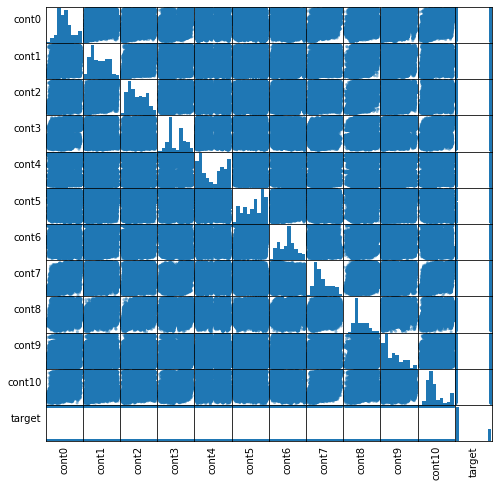

In [109]:
from pandas.plotting import scatter_matrix
import pandas as pd
df2=df[num]
numeric_data = df2.select(num).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Data Preperation

### Train/Test split

In [110]:
train, test = df.randomSplit([0.7, 0.3], seed=7)

print(f"Train set length: {train.count()} records")
print(f"Test set length: {test.count()} records")

Train set length: 209932 records
Test set length: 90068 records


In [111]:
#separating categorical and numerical features
cat_train = [x for (x, dataType) in train.dtypes if dataType == "string"]
num_train = [x for (x, dataType) in train.dtypes if ((dataType == "double") & (x != "target"))]

### String Indexing

In [112]:
#stringindexing actaully transform categorical data into numeric but with order. Therefore after stringindexing we do 
#one-hot encoding because our features are not ordinal, they are just nominal data
#importing OneHotEncoder and StringIndexer
from pyspark.ml.feature import (OneHotEncoder,StringIndexer,)
#creating string indexer for categorical columns
string_indexer = [StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip") for x in cat_train]

### One hot encoding

In [113]:
#creating one-hot encoder for string indexed columns
one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{x}_StringIndexer" for x in cat_train],
        outputCols=[f"{x}_OneHotEncoder" for x in cat_train])]

### Vector Assembling

In [114]:
#creating vector assembler
from pyspark.ml.feature import VectorAssembler
assemblerInput = [x for x in num_train]
assemblerInput += [f"{x}_OneHotEncoder" for x in cat_train]
vector_assembler = VectorAssembler(inputCols=assemblerInput, outputCol="VectorAssembler_features")

### Data Normalizer

In [115]:
from pyspark.ml.feature import Normalizer
#creating normalizer
normalizer = Normalizer(inputCol="VectorAssembler_features", outputCol="norm_VectorAssembler_features", p=1.0)

### Creating Data preprocessing pipeline (String indexing, One-Hot encoding, Vector assembling and Normalisation)

In [116]:
#Creating pipeline
#setting stages for Data preprocessing pipeline 
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages += [normalizer]

In [117]:
#creating Data preprocessing pipeline
#%%time
from pyspark.ml import Pipeline
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(train)

#transforming test and train data using Data preprocessing pipeline
train_df = model.transform(train)
test_df = model.transform(test)
#train_df.printSchema()

In [118]:
test_data = test_df.select(
    F.col("norm_VectorAssembler_features").alias("features"),
    F.col("target").alias("label"),)

train_data = train_df.select(
    F.col("norm_VectorAssembler_features").alias("features"),
    F.col("target").alias("label"),)

## Model building

### Logistic Regression

In [119]:
#K-FOLD CROSS VALIDATION
#%%time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression(maxIter=10)

#elasticNetParam is regularization parameter, to prevent overfitting
#fitIntercept is for weather we want to fit intercept for logistic or not
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
#t1 = train_data.sample(False, 0.1, 42)
#cvModel = crossval.fit(t1)
cvModel = crossval.fit(train_data)

In [122]:
#EVALUATION
#print("Coefficients: \n" + str(cvModel.coefficientMatrix))
trainingSummary = cvModel.bestModel.summary
AUC= trainingSummary.areaUnderROC
Intercept=cvModel.bestModel.interceptVector
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("AUC: %s\nIntercept: %s\nAccuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (AUC,Intercept,accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

AUC: 0.883997520316556
Intercept: [-1.0228688577149896]
Accuracy: 0.8449688470552369
FPR: 0.31124942495337754
TPR: 0.8449688470552369
F-measure: 0.8385922798640018
Precision: 0.8391567913485447
Recall: 0.8449688470552369


In [ ]:
#checing accuracy of all possible models
#cvModel.avgMetrics

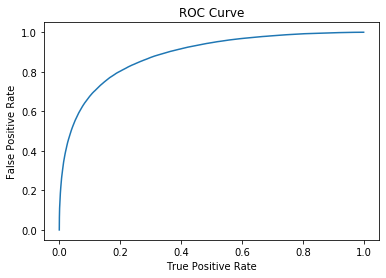

Training set areaUnderROC: 0.883997520316556


In [218]:
#plotting AUC
import matplotlib.pyplot as plt
import numpy as np
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

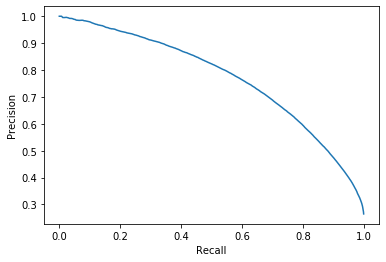

In [219]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### SVM Model

In [120]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10)

#elasticNetParam is regularization parameter, to prevent overfitting
#fitIntercept is for weather we want to fit intercept for logistic or not
paramGrid = ParamGridBuilder() \
    .addGrid(lsvc.regParam, [0.1, 0.01]) \
    .addGrid(lsvc.fitIntercept, [False, True]) \
    .build()

crossval = CrossValidator(estimator=lsvc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
lsvc_cvModel = crossval.fit(train_data)

In [150]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Compute predictions for test data
predictions = lsvc_cvModel.bestModel.transform(test_data)

# Show the computed predictions and compare with the original labels
#predictions.select("features", "label", "prediction").show(10)

# Define the evaluator method with the corresponding metric and compute the classification error on test data
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy')
#accuracy = evaluator.evaluate(predictions) 

# Show the accuracy
print("Intercept: " + str(lsvc_cvModel.bestModel.intercept))
print("Test accuracy = %g" % (accuracy))
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
#print("F1 Score = %s" % f1Score)

Intercept: 0.0
Test accuracy = 0.844969
Summary Stats
Precision = 0.8391567913485447
Recall = 0.8449688470552369


### Multilayer perceptron classifier
Multilayer perceptron classifier (MLPC) is a classifier based on the feedforward artificial neural network. 

In [158]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#x is number of input variables
x=train_data.schema["features"].metadata["ml_attr"]["num_attrs"]
layers = [x, 5, 4, 2]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
# train the model
model = trainer.fit(train_data)

In [159]:
predictions_mpc = model.transform(test_data)

## Model Evaluation

In [205]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
#Make predictions on the test set.
predictions_lr = cvModel.bestModel.transform(test_data)
predictions_svm = lsvc_cvModel.bestModel.transform(test_data)
predictions_mpc = model.transform(test_data)

#making evaluator objects
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_bi = BinaryClassificationEvaluator()

In [217]:
#function to generate evaluation metrics
def evaluation(prediction, pre,name):
    df = globals()[prediction]

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    if(tp + fn == 0.0):
        r = 0.0
        p = float(tp) / (tp + fp)
    elif(tp + fp == 0.0):
        r = float(tp) / (tp + fn)
        p = 0.0
    else:
        r = float(tp) / (tp + fn)
        p = float(tp) / (tp + fp)
                
    f1=0 if(p+r==0) else 2*((p*r)/(p+r))
    
    Accuracy = evaluator_multi.evaluate(pre)
    Test_Area_Under_ROC =  evaluator_bi.evaluate(pre)
    print(name)
    print("Accuracy: {} \nTest Area Under ROC: {}\nTrue Positives: {} \nTrue Negatives: {} \nFalse Positives: {} \nFalse Positives: {} \nRecall: {} \nPrecision: {} \nF1 score: {} ".
          format(Accuracy,Test_Area_Under_ROC,tp,tn,fp,fn,r,p,f1))

evaluation("predictions_svm",predictions_svm, "Linear Support Vector Machine")

Linear Support Vector Machine
Accuracy: 0.7595070227058236 
Test Area Under ROC: 0.8668606600147624
True Positives: 2254 
True Negatives: 66151 
False Positives: 50 
False Positives: 21610 
Recall: 0.09445189406637614 
Precision: 0.9782986111111112 
F1 score: 0.17227147661265668 
